In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
import statsmodels 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import fisher_exact

pd.set_option('display.max_rows', None)  # Отображение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [5]:
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')

starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 3600]
print(len(starts[starts.athlete_age < 16]))
starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)
starts = starts[starts['athlete_age'] > 18]
#индекс дискомфорта
starts['discomfort_index'] = starts['temp'] - (0.55 - 0.0055 * starts['humidity']) * (starts['temp'] - 14.5)

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  
print(starts.isnull().sum())
 



12219
record_id                                 0
athlete_id                                0
event_name                                0
event_date                                0
city                                      0
region                                    0
finish_time                               0
athlete_gender                            0
athlete_age                               0
is_newbie                                 0
temp                                      0
feels_like                                0
pressure                                  0
humidity                                  0
dew_point                                 0
clouds                                    0
wind_speed                                0
wind_deg                                  0
weather.main                              0
weather.description                       0
rain.1h                              147155
snow.1h                              153686
track_description_surface 

Я посмотрел, это происходит в набережных челнах и в каком-то городе московской области, что там на пробежках нет НИ одного волонтера. Это странно, кто же тогда считывал штрихкоды и тп? может быть потом я выкину эти пробежки, но пока просто заполню нулями что там 0 волонтеров (тк так оно и есть, nan появились из-за слияния что по event_name и event_date нет даже 1 волонтера хотя бы 1 роли)

In [6]:
# columns_to_fill = starts.columns.difference(['snow.1h', 'rain.1h'])  
# starts[columns_to_fill] = starts[columns_to_fill].fillna(0)  
# Удаляем строки, где есть NaN, кроме snow.1h и rain.1h  
print(len(starts))
starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])  
print(len(starts))


162262
161460


In [7]:
starts.loc[:,'is_repeated'] = starts.groupby('athlete_id')['event_date'].transform(lambda x: x.count() > 1)
starts['is_newbie'] = starts['is_newbie'].astype(int)
starts['is_repeated'] = starts['is_repeated'].astype(int)

Я решил выкинуть те самые 5 регионов, в которые 5 верст зашли во 2 половине 2023 года

In [8]:
starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  

In [9]:
starts = starts[starts.event_date >= '2023-01-01'] 
starts = starts[starts.event_date <= '2023-11-15']
# чтобы щас хотя бы как то резульаты были правдивые, я выкину крайние месяцы года, тк там люди могут перестать приходить из за погоды
newbie = starts[starts['is_newbie'] == 1]
print('кол-во уникальных бегунов, которые зарегались до 2023:', len(starts[starts['is_newbie'] == 0].drop_duplicates('athlete_id'))) 
print('кол-во новичков, которые пришли во 2 раз:',len(newbie[newbie.is_repeated == 1].drop_duplicates('athlete_id')))
print('кол-во новичков, которые не пришли после 1 раза:',len(newbie[newbie.is_repeated == 0].drop_duplicates('athlete_id')))

кол-во уникальных бегунов, которые зарегались до 2023: 8135
кол-во новичков, которые пришли во 2 раз: 8681
кол-во новичков, которые не пришли после 1 раза: 7807


In [10]:
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = newbie[newbie.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]

print(len(come), len(didnt_come))
first_runs.head(2)

8681 7807


,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated
106994,4827,790126879,Мещерский,2023-01-01,Одинцово,Московская область,2029,женский,38,1,0.85,-3.85,1007,100,0.85,100,5.0,200,Drizzle,light intensity drizzle,NaN,NaN,"гранитная крошка, грунт",0,0.85000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,0
107136,4783,790126912,Московский парк Победы,2023-01-01,Санкт-Петербург,Санкт-Петербург,1958,женский,38,1,3.86,-1.31,993,88,2.06,100,8.0,260,Rain,light rain,0.25,NaN,смешанное,0,4.56224,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1


In [11]:
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)
num_col = come_with_didnt_come.select_dtypes('number')



print(num_col.corr(method="spearman")['is_repeated'])
display(come_with_didnt_come.head(2))


record_id                           -0.139906
athlete_id                          -0.146201
finish_time                         -0.090614
athlete_age                          0.097584
is_newbie                                 NaN
temp                                -0.015801
feels_like                          -0.020289
pressure                            -0.022094
humidity                            -0.037028
dew_point                           -0.041950
clouds                              -0.025675
wind_speed                           0.043231
wind_deg                             0.038581
rain.1h                              0.190192
snow.1h                             -0.127482
is_male                              0.049989
discomfort_index                    -0.018471
Ведущий велосипед                   -0.044121
Завершение мероприятия              -0.048296
Замыкающий                          -0.119075
Инструктаж новых участников         -0.040704
Координатор парковки              

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers
107136,4783,790126912,Московский парк Победы,2023-01-01,Санкт-Петербург,Санкт-Петербург,1958,женский,38,1,3.86,-1.31,993,88,2.06,100,8.00,260,Rain,light rain,0.25,NaN,смешанное,0,4.56224,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1,16.0
107139,4800,790126914,Жуковский,2023-01-01,Жуковский,Московская область,1851,мужской,45,1,1.12,-2.26,1008,100,1.12,100,3.13,180,Drizzle,light intensity drizzle,NaN,0.22,смешанное,1,1.12000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1,15.0


Откинем не стат значимые корреляции и сделаем логит модель.

In [12]:
insignificant_vars = []  

# Обходим все целочисленные столбцы  

for col in num_col.columns:      
    try:
        if col != 'is_repeated':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(num_col[col], num_col['is_repeated'])  

        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
num_col_starts = num_col.drop(columns=insignificant_vars)  


Неподходящие целочисленные переменные: ['Координатор парковки', 'Лидер для слабовидящих', 'Организация финиша', 'Пейсер', 'Раздача карточек позиций', 'Составление отчёта', 'Сурдопереводчик']
7


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='cnt_volunteers', ylabel='Count'>

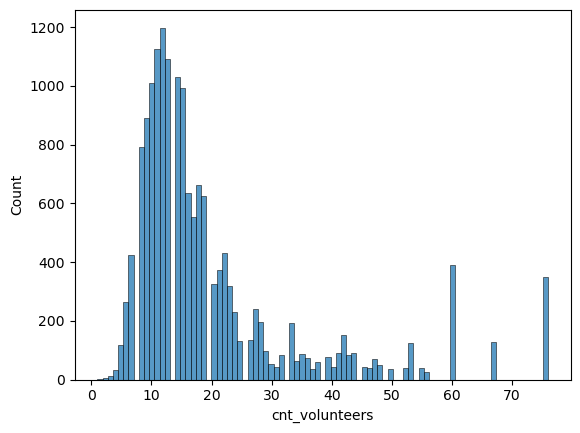

In [13]:
sns.histplot(num_col_starts.cnt_volunteers)

Семен делает статтесты для проверки значимости разницы средних выборок С опред. волонтерами и БЕЗ них

In [14]:
come_with_didnt_come.Маршал.value_counts()

Маршал
0.0     5364
1.0     3934
2.0     2299
3.0     1444
5.0      724
4.0      708
11.0     478
6.0      467
27.0     349
13.0     192
7.0      170
9.0      133
8.0       95
12.0      67
10.0      39
15.0      25
Name: count, dtype: int64

In [15]:
come_with_didnt_come['Инструктаж новых участников'].value_counts()

Инструктаж новых участников
0.0    10066
1.0     6208
2.0      144
3.0       70
Name: count, dtype: int64

In [16]:
with_marshal_and_instr = come_with_didnt_come[['Маршал', 'Инструктаж новых участников', 'is_repeated']]

In [19]:
marshal_0 = with_marshal_and_instr[with_marshal_and_instr.Маршал == 0].is_repeated
marshal_1 = with_marshal_and_instr[with_marshal_and_instr.Маршал >= 1].is_repeated
print(marshal_0.shape[0], marshal_1.shape[0], marshal_1.value_counts()[1]/marshal_1.shape[0], marshal_0.value_counts()[1]/marshal_0.shape[0])

5364 11124 0.506202804746494 0.5686055182699478


In [20]:
marshal_0.value_counts()

is_repeated
1    3050
0    2314
Name: count, dtype: int64

In [21]:
marshal_1.value_counts()

is_repeated
1    5631
0    5493
Name: count, dtype: int64

Доля успехов не экстремальна, выборка достаточно большая ==> для сравнения выборок будем делать двухпропорциональный Z-тест на долях 

In [22]:
x1 = marshal_0.value_counts()[1]
n1 = marshal_0.shape[0]
x2 = marshal_1.value_counts()[1]
n2 = marshal_1.shape[0]
count = [x1, x2]
nobs = [n1, n2]
stats, pval = statsmodels.stats.proportion.proportions_ztest(count, nobs, value=0)
print('Z-value:', stats)
print('p value:', pval)

Z-value: 7.51857214281303
p value: 5.537768600278418e-14


In [23]:
volunteers_cols = come_with_didnt_come.columns[25:52]  
results = []

for vol in volunteers_cols:
    group_vol = come_with_didnt_come[come_with_didnt_come[vol] > 0]
    group_no_vol = come_with_didnt_come[come_with_didnt_come[vol] == 0]
    
    x1 = group_vol['is_repeated'].sum()
    n1 = group_vol.shape[0]
    x2 = group_no_vol['is_repeated'].sum()
    n2 = group_no_vol.shape[0]


    if min(x1, n1 - x1, x2, n2 - x2) < 5:
        table = np.array([[x1, n1 - x1],
                          [x2, n2 - x2]])
        oddsratio, p_value = fisher_exact(table)
        test_type = 'Fisher'
    else:
        count = [x1, x2]
        nobs = [n1, n2]
        stat, p_value = proportions_ztest(count, nobs, value=0)
        test_type = 'Z-test'
    
    results.append({
        'volunteer': vol,
        'test_type': test_type,
        'p_value': p_value,
        'n1': n1,
        'n2': n2,
        'p1': x1/n1 if n1>0 else np.nan,
        'p2': x2/n2 if n2>0 else np.nan,
        'significant': 1 if p_value<0.05 else 0
    })
    z_results = pd.DataFrame(results)

In [24]:
z_results

,volunteer,test_type,p_value,n1,n2,p1,p2,significant
0,Ведущий велосипед,Z-test,1.418750e-08,279,16209,0.358423,0.529397,1
1,Завершение мероприятия,Z-test,4.549994e-11,2062,14426,0.458778,0.536185,1
2,Замыкающий,Z-test,2.152021e-02,16287,201,0.525511,0.606965,1
3,Инструктаж новых участников,Z-test,1.261117e-07,6422,10066,0.500779,0.542917,1
4,Координатор парковки,Z-test,7.726257e-02,108,16380,0.611111,0.525946,0
5,Координация волонтёров,Z-test,1.910716e-51,3185,13303,0.406593,0.555213,1
6,Лидер для слабовидящих,Z-test,1.752359e-01,321,16167,0.489097,0.527247,0
7,Маршал,Z-test,5.537769e-14,11124,5364,0.506203,0.568606,1
8,Обработка результатов,Z-test,1.488392e-02,12610,3878,0.521253,0.543579,1
9,Организатор,Z-test,3.717036e-01,16446,42,0.526329,0.595238,0
